## Exploration of the Estonian - Latvian Dataset

In [1]:
# General Imports

library(ggh4x)
library(writexl)
library(marginaleffects)
library(readxl)
library(vegan)
library(ggplot2)
library(SRS)
library(tidyverse)
library(divermeta)
library(kableExtra)
library(FSA)
library(latex2exp)
library(cowplot)
library(patchwork)
library(gridExtra)
library(pheatmap)
library(multcompView)
library(permuco)
library(rlang)

source("utils/general_functions.R")

Loading required package: ggplot2

Loading required package: permute

Loading required package: shiny

Loading required package: DT


Attaching package: ‘DT’


The following objects are masked from ‘package:shiny’:

    dataTableOutput, renderDataTable


Loading required package: shinycssloaders

Loading required package: shinybusy

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


## FSA v0.10.0. See citation('FSA') if used in publication

## Distance Based Multiplicity

In [2]:
data  <- qs::qread("EST-LAT/vegetation.qs")

In [3]:
df_vegetation  <- data$metaveg
head(df_vegetation)

SampleID,vegetation_type
<chr>,<chr>
S208,forest
S227,forest
S678,forest
S480,forest
EE14,forest
S475,forest


In [4]:
# Reads
abundance_file <- "EST-LAT/EstLat_Veg-DenoisedTable.txt"
df_abbundance  <- read_tsv(abundance_file, col_types = cols())

head(df_abbundance)

ID_Clustered,ID_Denoised,EE11,EE14,G2767,G2819,G2830,G2847,G3449,G3518,⋯,S554,S557,S558,S579,S581,S589,S675,S678,S684,s508
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00162b030fcce9f3eb5ff75f5dc59030011424b6,00162b030fcce9f3eb5ff75f5dc59030011424b6,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,136ef4e86fce021b0c47bf1e9a8c812a1037e880,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,3ac6bdd6450091c7220da89616ef0477732a6b8b,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,49074181339a6c8a1f8531c6b02d9706f411c4ea,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,771d7cdd9b7bd4c53f8a74d698f3e8ac17c87506,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
00162b030fcce9f3eb5ff75f5dc59030011424b6,d0a0d5ba9e58e7bab7cfb518d60803959c79bf17,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
# Generates the files
diss_file <- "EST-LAT/EstLat_SeqDistances/unified_distances.csv"
diss_clust_file <- "EST-LAT/EstLat_SeqDistances/unified_distances_clusters.csv"


#  Wites the empty headers
base_tibble  <- tibble(ID1 = character(), ID2 = character(), Distance = numeric())
write.table(base_tibble, file = diss_file, sep = ",", row.names = FALSE, col.names = TRUE)
write.table(base_tibble, file = diss_clust_file, sep = ",", row.names = FALSE, col.names = TRUE)

In [6]:
# Unifies distances

base_clusters <- df_abbundance %>% 
        select(ID_Clustered, ID_Denoised)

clusts_ids  <- unique(base_clusters$ID_Clustered)


# Iterates over each of the clusters to construct further clusters
dfs  <- list()

i <- 0
total_clust <- length(unique(base_clusters$ID_Clustered))

# Saves the inner distances
for (base_clust_id in clusts_ids) {

    i <-  i +1
    # print(paste(base_clust_id, i,"of", total_clust, sep = " "))
    flush.console()

    # Extract the current ids
    df_ids <- base_clusters %>% 
        filter(ID_Clustered == base_clust_id) %>% 
        select(ID_Denoised) %>% 
        distinct()

    num_ids <- nrow(df_ids)
    # print(num_ids)

    if(num_ids == 1)
    {
        dfs[[base_clust_id]]  <- data.frame(ID1 = df_ids$ID_Denoised, ID2 = df_ids$ID_Denoised, Distance = 0)
        next
    }


    # Loads the distance file
    dist_file <- paste("EST-LAT/EstLat_SeqDistances/Split_OTUs_Distances/",base_clust_id,".txt", sep="")
    df_dist  <- read_tsv(dist_file, col_types = cols(), col_names = c("ID1", "ID2", "Distance"))

    df_dist <- df_dist %>% 
    filter(ID1 %in% df_ids$ID_Denoised & ID2 %in% df_ids$ID_Denoised)

    dfs[[base_clust_id]]  <- df_dist
}

dfs_distances <- bind_rows(dfs)

#  Saves
write_csv(dfs_distances, diss_file, append = TRUE, col_names = FALSE)


In [7]:
max(dfs_distances$Distance)

[1] 0.049

In [8]:
#  Selectes the relevant columns for the taxa

taxa_level <- "Genus"
print(taxa_level)

cols <- c('QueryName','Order','Family','Genus','Species')

df_taxa <- data$taxveg %>% select(all_of(cols)) %>% dplyr::rename(ID_Clustered = QueryName)

totals <- table(df_taxa[[taxa_level]])
df_order <- tibble(Taxa = names(totals), Count = as.vector(totals))
df_order <- df_order %>% arrange(-Count)

print(paste("Total Groups: ", nrow((df_order))))

selected_genus <- c(
"Cenococcum",
"Cortinarius",
"Russula",
"Sebacina" ,
"Hebeloma",
"Tuber"
)

df_order <- df_order %>% filter(Taxa %in% selected_genus )

print(paste("Total Groups Selected Groups: ", nrow((df_order))))


df_order


[1] "Genus"


[1] "Total Groups:  81"
[1] "Total Groups Selected Groups:  6"


Taxa,Count
<chr>,<int>
Cortinarius,237
Russula,164
Sebacina,133
Hebeloma,39
Tuber,26
Cenococcum,21


In [9]:
included_vegetation <- c('forest', 'park', 'energy plantation')

unique(df_vegetation$vegetation_type)
table(df_vegetation$vegetation_type)

[1] "forest"            "ruins"             "energy plantation"
[4] "park"              "alley"             "woodland"


            alley energy plantation            forest              park 
               14                23                25                25 
            ruins          woodland 
               25                25 

In [10]:

clust_distances <- seq(from = 0.002, to = 0.046, by = 0.002)


sample_ids <- colnames(df_abbundance  %>% select(-ID_Denoised,-ID_Clustered))


vals <- c()
divs <- c()


i <- 0

taxa_groups <- df_order %>% pull(Taxa)

rows <- list()

for(sampleID in sample_ids)
{
        
    i  <- i + 1
    print(paste(sampleID, i, "of", length(sample_ids), sep = " "))
    flush.console()

    veg_type  <- df_vegetation %>% filter(SampleID == sampleID) %>% pull(vegetation_type)

    if(!(veg_type %in%  included_vegetation))
        next


    df_abbundance_sample <- df_abbundance %>% 
        select(ID_Clustered, ID_Denoised, all_of(sampleID))  %>% 
        rename(Abundance = all_of(sampleID)) %>% 
        filter(Abundance > 0)

    # First for all Taxa    
    df_abbundance_taxa <- df_abbundance_sample 
    ids_denoised <- df_abbundance_taxa %>% pull(ID_Denoised)
    
    diss <-  dfs_distances %>% filter(ID1 %in% ids_denoised) %>% filter(ID2 %in% ids_denoised)
    ids <- df_abbundance_taxa$ID_Denoised
    ab <- df_abbundance_taxa$Abundance
    clust <- df_abbundance_taxa$ID_Clustered


    for(sigma in clust_distances)
    {

        ab_clust <- tapply(ab, clust, sum)

        m <- multiplicity.distance.by_blocks(ids, ab, diss, clust, sigma)
        d <- renyi(ab_clust, hill = TRUE, scales = 1)[[1]]

        rows[[length(rows) + 1]]  <- c(sampleID, "All", sigma, m, d, veg_type)

    }


        
    for(txg in taxa_groups)
    {

        cluster_ids <- df_taxa %>% filter(!!sym(taxa_level) == txg) %>% pull(ID_Clustered)
        df_abbundance_taxa <- df_abbundance_sample %>% filter(ID_Clustered %in% cluster_ids)
        ids_denoised <- df_abbundance_taxa %>% pull(ID_Denoised)
        
        diss <-  dfs_distances %>% filter(ID1 %in% ids_denoised) %>% filter(ID2 %in% ids_denoised)
        ids <- df_abbundance_taxa$ID_Denoised
        ab <- df_abbundance_taxa$Abundance
        clust <- df_abbundance_taxa$ID_Clustered


        for(sigma in clust_distances)
        {

            if(length(ids) == 0) {
                rows[[length(rows) + 1]]  <- c(sampleID, txg, sigma, 0, 0, veg_type)
                next
            }
            
            if(length(ids) == 1)
            {
                rows[[length(rows) + 1]]  <- c(sampleID, txg, sigma, 1, 1, veg_type)
                next
            }


            ab_clust <- tapply(ab, clust, sum)

            m <- multiplicity.distance.by_blocks(ids, ab, diss, clust, sigma)
            d <- renyi(ab_clust, hill = TRUE, scales = 1)[[1]]

            rows[[length(rows) + 1]]  <- c(sampleID, txg, sigma, m, d, veg_type)

        }

    }


}


df_result <- do.call(rbind, rows)
colnames(df_result) <- c("SampleID","Taxa", "sigma", "delta_M", "D", "Veg")

df_result <-  as_tibble(df_result) %>%
  mutate(delta_M = as.numeric(delta_M), D = as.numeric(D), sigma = as.numeric(sigma), Taxa = as.factor(Taxa), Veg = as.factor(Veg)) 

df_result


[1] "EE11 1 of 137"
[1] "EE14 2 of 137"
[1] "G2767 3 of 137"
[1] "G2819 4 of 137"
[1] "G2830 5 of 137"
[1] "G2847 6 of 137"
[1] "G3449 7 of 137"
[1] "G3518 8 of 137"
[1] "G3561 9 of 137"
[1] "G3566 10 of 137"
[1] "G3574 11 of 137"
[1] "G3575 12 of 137"
[1] "G4085 13 of 137"
[1] "G4086 14 of 137"
[1] "G4097 15 of 137"
[1] "G4101 16 of 137"
[1] "G4103 17 of 137"
[1] "G4118 18 of 137"
[1] "G4127 19 of 137"
[1] "G4164 20 of 137"
[1] "G4169 21 of 137"
[1] "G4173 22 of 137"
[1] "G4175 23 of 137"
[1] "G4195 24 of 137"
[1] "G4200 25 of 137"
[1] "G4207 26 of 137"
[1] "G4214 27 of 137"
[1] "G4223 28 of 137"
[1] "G4232 29 of 137"
[1] "G4242 30 of 137"
[1] "G4246 31 of 137"
[1] "G4247 32 of 137"
[1] "G4275 33 of 137"
[1] "G4276 34 of 137"
[1] "G4279 35 of 137"
[1] "G4280 36 of 137"
[1] "G4283 37 of 137"
[1] "G4310 38 of 137"
[1] "G4311 39 of 137"
[1] "G4343 40 of 137"
[1] "G4345 41 of 137"
[1] "G4352 42 of 137"
[1] "G4353 43 of 137"
[1] "G4355 44 of 137"
[1] "G4375 45 of 137"
[1] "G4377 46 of 137"

SampleID,Taxa,sigma,delta_M,D,Veg
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
EE11,All,0.002,2.186129,64.40306,forest
EE11,All,0.004,1.582627,64.40306,forest
EE11,All,0.006,1.414397,64.40306,forest
EE11,All,0.008,1.322977,64.40306,forest
EE11,All,0.010,1.262972,64.40306,forest
EE11,All,0.012,1.220065,64.40306,forest
EE11,All,0.014,1.188825,64.40306,forest
EE11,All,0.016,1.164786,64.40306,forest
EE11,All,0.018,1.145724,64.40306,forest


In [11]:
 
 
printLatexPermanovaResults <- function(perm_model, caption, label)
{

    # Extract ANOVA table and compute eta²
    anova_df <- as.data.frame(perm_model$table)
    
    #  print(anova_df)
    
    anova_df <- anova_df %>%
        mutate(
        eta = round(SS / sum(SS) * 100, 2),
        `F value` = round(F, 2),
        `resampled Pr(>F)` = round(`resampled P(>F)`, 4)    
        ) %>%
        select(df, eta, SS, `F value`, `resampled Pr(>F)`)
    
    # Format for LaTeX
    anova_latex <- anova_df %>%
        mutate(
        `resampled Pr(>F)` = case_when(
            `resampled Pr(>F)` < 0.001 ~ paste0(sprintf("%.4f", `resampled Pr(>F)`), " ***"),
            `resampled Pr(>F)` < 0.01  ~ paste0(sprintf("%.4f", `resampled Pr(>F)`), " ** "),
            `resampled Pr(>F)` < 0.05  ~ paste0(sprintf("%.4f", `resampled Pr(>F)`), " *  "),
            TRUE             ~ sprintf("%.4f", `resampled Pr(>F)`)
        ),
        `SS`  = sprintf("%.2f", SS),
        eta = sprintf("%.2f", eta),
        `F value`  = sprintf("%.2f", `F value`)
        ) %>%
        rename(
        `Degrees of Freedom` = df,
        `Sum Sq` = `SS`,
        `$\\eta^2$` = eta,
        `p-value (Resampled)` = `resampled Pr(>F)`
        )
    
    tab <- kable(anova_latex, format = "latex", booktabs = TRUE,
                caption = caption,
                #  label = paste0("tab:anova_results_", target_col),
                align = c("r", "r", "r", "r", "l"), escape = FALSE) %>%
        kable_styling(latex_options = c("hold_position"))
    
    cat(gsub("end{tabular}", paste0("end{tabular}\n\\label{","tab:", label, "}"), tab,fixed = TRUE))
    cat("\n\n")
}



# Fixes seed
set.seed(161)
np  <- 10000



sig <- 0.02
df_analysis  <- df_result %>% filter(sigma == sig) %>% filter(Taxa != "All")

df_analysis$Taxa  <- as.factor(df_analysis$Taxa)
df_analysis$Veg  <- as.factor(df_analysis$Veg)

grid <- data.frame(Taxa = unique(df_analysis$Taxa), Veg = "alley")
grid$Veg <- factor(grid$Veg, levels = levels(df_analysis$Veg))

# Distance Based Multplicity
print("Distance Based Multiplicity")

# Run permutation ANOVA
model_m <- aov(delta_M ~ Taxa * Veg, data = df_analysis)
perm_model_m <- aovperm(delta_M ~ Taxa * Veg,
                      data = df_analysis,
                      np = np, # number of permutations
                      progress = FALSE)

# Extract ANOVA table and compute eta²
df_anova_m <- as.data.frame(perm_model_m$table)
df_anova_m <- df_anova_m %>% mutate(eta = round(100* SS / sum(.data$SS), 2)) 
df_anova_m <- cbind(id = rownames(df_anova_m), df_anova_m)
df_anova_m

printLatexPermanovaResults(perm_model_m, caption = "Permutation ANOVA results for the $\\delta M_{0.002}$ model for taxonomic fungi samples
from northern Baltic region", label = "anova_distance_multiplicity_tax_balt")


df_marginal_m <- comparisons(model_m, variables = "Veg", newdata = grid) %>% 
                 mutate(contrast.var = str_split_fixed(contrast, " - ", 2)[, 1])


# Diversity

print("Diversity")

# Run permutation ANOVA
model_d <- aov(D ~ Taxa * Veg, data = df_analysis)
perm_model_d <- aovperm(D ~ Taxa * Veg,
                      data = df_analysis,
                      np = np, # number of permutations
                      progress = FALSE)

# Extract ANOVA table and compute eta²
df_anova_d <- as.data.frame(perm_model_d$table)
df_anova_d <- df_anova_d %>% mutate(eta = round(100* SS / sum(.data$SS), 2)) 
df_anova_d <- cbind(id = rownames(df_anova_d), df_anova_d)
df_anova_d

printLatexPermanovaResults(perm_model_d, caption = "Permutation ANOVA results for the $^1 D$ model for taxonomic fungi samples
from northern Baltic region", label = "anova_diversity_tax_balt")

df_marginal_d <- comparisons(model_d, variables = "Veg", newdata = grid)  %>% 
                mutate(contrast.var = str_split_fixed(contrast, " - ", 2)[, 1])



[1] "Distance Based Multiplicity"


,id,SS,df,F,parametric P(>F),resampled P(>F),eta
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Taxa,Taxa,6.039397,5,10.33710,2.308264e-09,1e-04,7.23
Veg,Veg,11.580537,2,49.55346,0.000000e+00,1e-04,13.87
Taxa:Veg,Taxa:Veg,16.787228,10,14.36661,0.000000e+00,1e-04,20.11
Residuals,Residuals,49.076543,420,NA,NA,NA,58.79


\begin{table}[!h]
\centering
\caption{Permutation ANOVA results for the $\delta M_{0.002}$ model for taxonomic fungi samples
from northern Baltic region}
\centering
\begin{tabular}[t]{lrrrrl}
\toprule
  & Degrees of Freedom & $\eta^2$ & Sum Sq & F value & p-value (Resampled)\\
\midrule
Taxa & 5 & 7.23 & 6.04 & 10.34 & 0.0001 ***\\
Veg & 2 & 13.87 & 11.58 & 49.55 & 0.0001 ***\\
Taxa:Veg & 10 & 20.11 & 16.79 & 14.37 & 0.0001 ***\\
Residuals & 420 & 58.79 & 49.08 & NA & NA\\
\bottomrule
\end{tabular}
\label{tab:anova_distance_multiplicity_tax_balt}
\end{table}

[1] "Diversity"


,id,SS,df,F,parametric P(>F),resampled P(>F),eta
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Taxa,Taxa,1141.267,5,51.50992,0,1e-04,19.81
Veg,Veg,1320.696,2,149.02061,0,1e-04,22.92
Taxa:Veg,Taxa:Veg,1438.859,10,32.47072,0,1e-04,24.97
Residuals,Residuals,1861.126,420,NA,NA,NA,32.30


\begin{table}[!h]
\centering
\caption{Permutation ANOVA results for the $^1 D$ model for taxonomic fungi samples
from northern Baltic region}
\centering
\begin{tabular}[t]{lrrrrl}
\toprule
  & Degrees of Freedom & $\eta^2$ & Sum Sq & F value & p-value (Resampled)\\
\midrule
Taxa & 5 & 19.81 & 1141.27 & 51.51 & 0.0001 ***\\
Veg & 2 & 22.92 & 1320.70 & 149.02 & 0.0001 ***\\
Taxa:Veg & 10 & 24.97 & 1438.86 & 32.47 & 0.0001 ***\\
Residuals & 420 & 32.30 & 1861.13 & NA & NA\\
\bottomrule
\end{tabular}
\label{tab:anova_diversity_tax_balt}
\end{table}



In [12]:
# Create a named list of data frames
sheets <- list(
  "All Results"                     = df_result,
  "Analysis Results (sigma 0.02)"   = df_analysis,
  "Multiplicity ANOVA Perm Results" = df_anova_m,
  "Multiplicity Marginal Results"   = df_marginal_m,
  "Diversity ANOVA Perm Results"    = df_anova_d,
  "Diversity Marginal Results"      = df_marginal_d
)

# Write to Excel file
write_xlsx(sheets, path = paste0("EST-LAT/results/", "results_", tolower(taxa_level) ,".xlsx"))



### Sigificance Analysis

Warning message:
“`geom_errobarh()` was deprecated in ggplot2 4.0.0.
ℹ Please use the `orientation` argument of `geom_errorbar()` instead.”
`height` was translated to `width`.
`height` was translated to `width`.
`height` was translated to `width`.


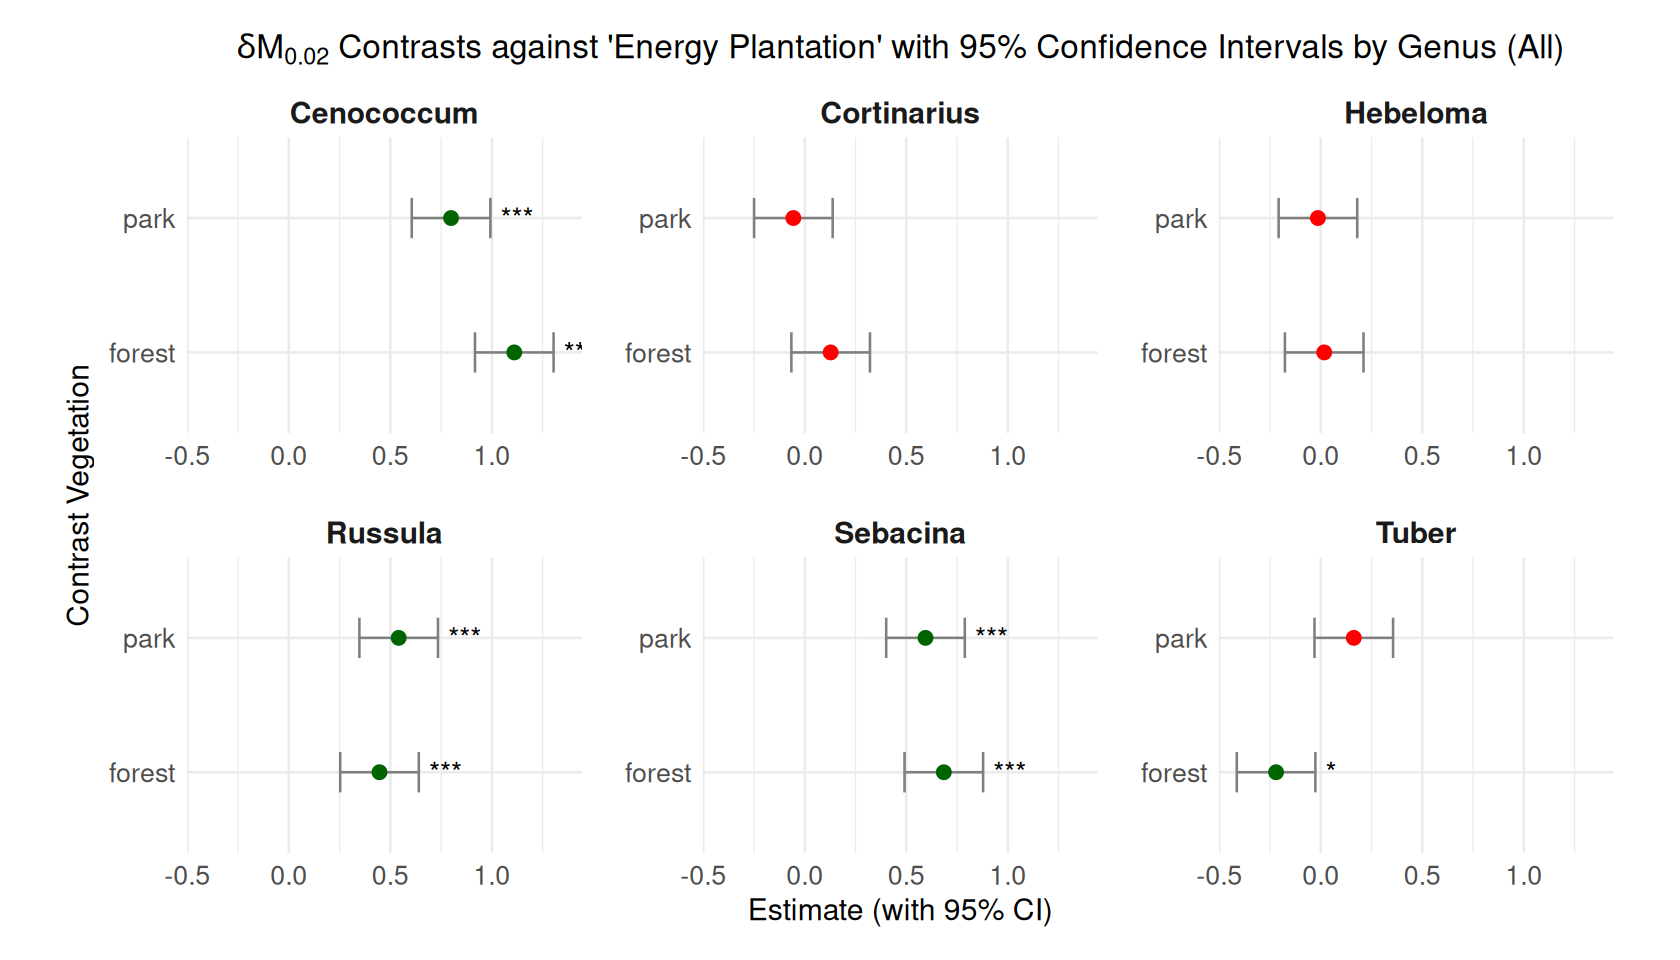

`height` was translated to `width`.


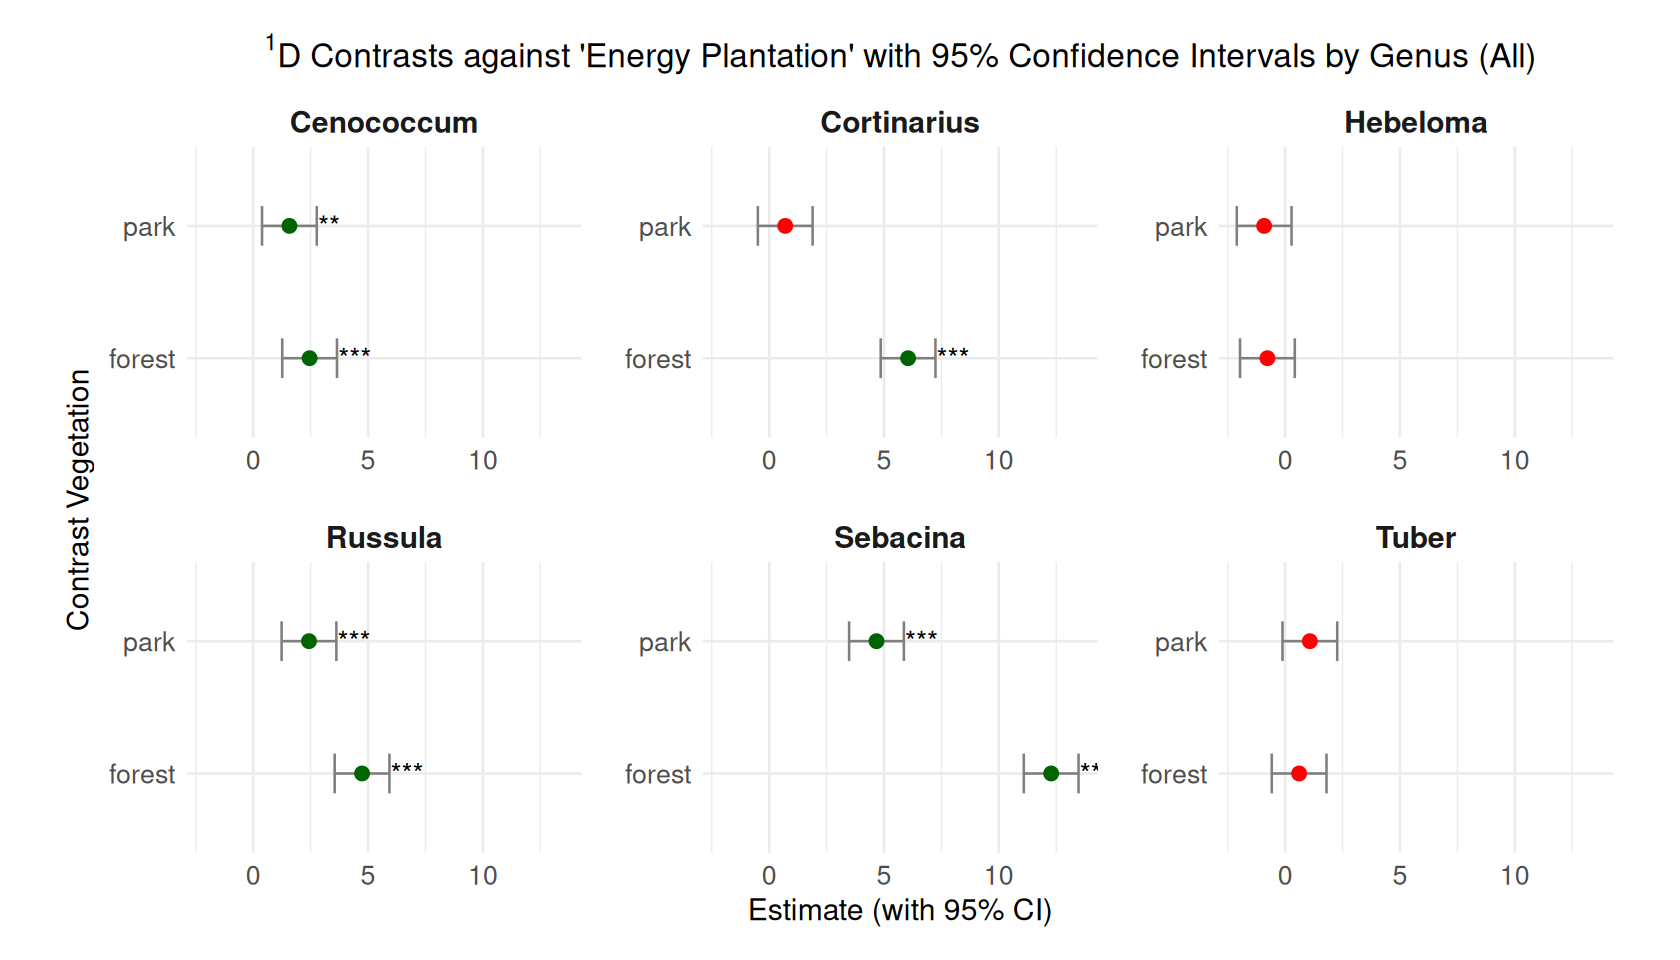

In [13]:
# Multiplicity
set.seed(1)


# Marginal

make_chart = function (df, title, ncols = 4)
{

      # Create significance stars
      df <- df %>%
        mutate(
          signif = case_when(
            p.value < 0.001 ~ "***",
            p.value < 0.01  ~ "**",
            p.value < 0.05  ~ "*",
            TRUE            ~ ""
          ),
          is_signif = p.value < 0.05  # logical flag
        )



      # Plot
      p <- ggplot(df, aes(y = contrast.var)) +
        geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.3, color = "grey50") +
        geom_point(aes(x = estimate, color = is_signif), size = 3.5) +
        geom_text(aes(x = conf.high + 0.05, label = signif), size = 6, hjust = 0) +
        scale_color_manual(values = c(`TRUE` = "darkgreen", `FALSE` = "red"), guide = "none") +
        facet_wrap2(~ Taxa, scales = "fixed", ncol = ncols, axes = "all") +
        theme_minimal(base_size = 16) +
        labs(
          title = title,
          x = "Estimate (with 95% CI)",
          y = "Contrast Vegetation"
        ) +
        theme(
          plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
          strip.text = element_text(size = 18, face = "bold"),
          axis.title = element_text(size = 18),
          axis.text = element_text(size = 16),
          plot.margin = margin(t = 20, r = 40, b = 20, l = 40),
          panel.spacing = unit(1.5, "lines")
        )

}

options(repr.plot.width = 14, repr.plot.height = 8)

# Multiplicity
df <- df_marginal_m

p_all <- make_chart(df, ncols = 3, title = TeX(paste0("$\\delta M_{0.02}$ Contrasts against 'Energy Plantation' with 95% Confidence Intervals by ", taxa_level,  " (All)")))
# p_sig <- make_chart(df %>% filter(p.value  <=  0.05), ncols = 3, title = TeX(paste0("$\\delta M_{0.02}$ Contrasts against 'Energy Plantation' with 95% Confidence Intervals by ", taxa_level, " (Significant at 0.05)")))

print(p_all)
# print(p_sig)


ggsave(paste0("EST-LAT/results/plots/", tolower(taxa_level), "_multiplicity_all.png"), plot = p_all, width = 14, height = 8, dpi = 400, bg = "white")
# ggsave(paste0("EST-LAT/results/plots/", tolower(taxa_level), "_multiplicity_significant.png"), plot = p_sig, width = 16, height = 15, dpi = 400, bg = "white")

# Diversity

df <- df_marginal_d

p_all <- make_chart(df, ncols = 3, title = TeX(paste0("$^1D$ Contrasts against 'Energy Plantation' with 95% Confidence Intervals by ", taxa_level,  " (All)")))
# p_sig <- make_chart(df %>% filter(p.value  <=  0.05), ncols = 3, title = TeX(paste0("$^1D$ Contrasts against 'Energy Plantation' with 95% Confidence Intervals by ", taxa_level,  " (Significant at 0.05)")))

print(p_all)
# print(p_sig)


ggsave(paste0("EST-LAT/results/plots/", tolower(taxa_level), "_diversity_all.png"), plot = p_all, width = 14, height = 8, dpi = 400, bg = "white")
# ggsave(paste0("EST-LAT/results/plots/", tolower(taxa_level), "_diversity_significant.png"), plot = p_sig, width = 16, height = 15, dpi = 400, bg = "white")



## Diversity vs Multiplicity Plots

In [14]:
DEBUG = FALSE

set.seed(1)

rows <- list()

for(txg in c(taxa_groups))
{

      cat(paste0("% --------- ", txg, " ----------\n"))
      flush.console()
      
      df_plot <- df_analysis %>% filter(Taxa == txg)



      # Parameterrs
      df <- df_plot

      multiplicity_col <- "delta_M"
      diversity_col <- "D"
      group_col <- "Veg"
      diversity_name <- "Diversity $^1D$"
      group_name <- "Vegetation Type"
      multiplicity_name <- paste0("Distance-based Multiplicity $\\delta \\, M_{", sig, "}$", sep = "")

      label_map <- c('forest' = "Forest (F)",                    
                    'park' = 'Park (P)',                     
                    'energy plantation' = "Energy Plantation (EP)"              
                    )

      short_label_map <- c(
                    'forest' = "F",                    
                    'park' = 'P',                     
                    'energy plantation' = "EP"                    
                    )

      label_order <- c('forest', 'park', 'energy plantation')


      custom_colors <- c(
                    '#7D917E',                 
                    '#DAC5AA',
                    '#BE5E58'
      )
      

      title <- TeX(paste0("\\textit{", txg, "} Distance-based Multiplicity $\\delta \\, M_{", sig, "}$ vs Diversity $^1D$", sep = ""))
      if(txg == "All")
          title <- TeX(paste0("Distance-based Multiplicity $\\delta \\, M_{", sig, "}$ vs Diversity $^1D$", sep = ""))
          



      plot_location <- paste0("EST-LAT/results/plots/", tolower(taxa_level),"/", tolower(txg), "_combined.png")

      short_label_order <- as.vector(short_label_map[label_order])
    
      kw_caption <- paste0("Kruskal-Wallis test results for diversity ($^1D$) and distance-based multiplicity ($\\delta M_{0.02}$) comparing the different vegetation types for genus \\textit{",txg,"}")
      dun_caption <- paste0("Dunn's Test Results for Diversity ($^1D$) and distance-based multiplicity ($\\delta M_{0.02}$) comparing different vegetation types for genus \\textit{",txg,"}")

      
      kw_label <- paste0("tab:kw_results_balt_", str_to_lower(txg))
      dunn_label <- paste0("tab:dunn_results_balt_", str_to_lower(txg))


      # Tests
      tests_resp <- kw_and_dunn_test(
        df_test = df,
        order = label_order,
        labels = short_label_order, 
        multiplicity_col = multiplicity_col,
        diversity_col = diversity_col,
        group_col = group_col,
        diversity_name = diversity_name,
        group_name = group_name,
        multiplicity_name = multiplicity_name,
        kw_caption = kw_caption,
        dun_caption = dun_caption,
        kw_label = kw_label,
        dunn_label = dunn_label
      )

      compute_cld(dunn_result = tests_resp$dunn_div, short_label_order = short_label_order, label_order = label_order)

      # Prints

    if(DEBUG)
    {
      print(tests_resp$kw_df)
      cat("\n\n")
      print(tests_resp$dunn_df)
      flush.console()

    }
    else {
       
      cat(tests_resp$kw_table)
      cat("\n\n")
      cat(tests_resp$dunn_table)
      flush.console()
    }



    # Compact Letter Display
    cld_div <- compute_cld(dunn_result = tests_resp$dunn_div, short_label_order = short_label_order, label_order = label_order)
    cld_mul <- compute_cld(dunn_result = tests_resp$dunn_mul, short_label_order = short_label_order, label_order = label_order)
    
    rows[[length(rows) + 1]] <- tibble(Taxa = txg, Veg = label_order, D = cld_div$Letters[label_order], delta_M= cld_mul$Letters[label_order])
    
    cat("\n\n\n\n")
    flush.console()
      
}

      



% --------- Cortinarius ----------
\begin{table}[!h]
\centering
\caption{Kruskal-Wallis test results for diversity ($^1D$) and distance-based multiplicity ($\delta M_{0.02}$) comparing the different vegetation types for genus \textit{Cortinarius}}
\centering
\begin{tabular}[t]{lrrl}
\toprule
Metric & $\chi^2$ & df & p-val\\
\midrule
Diversity $^1D$ & 38.14417 & 2 & 0.0001 ***\\
Distance-based Multiplicity $\delta M_{0.02}$ & 15.65099 & 2 & 0.0004 ***\\
\bottomrule
\end{tabular}
\label{tab:kw_results_balt_cortinarius}
\end{table}

\begin{table}[!h]
\centering
\caption{Dunn's Test Results for Diversity ($^1D$) and distance-based multiplicity ($\delta M_{0.02}$) comparing different vegetation types for genus \textit{Cortinarius}}
\centering
\begin{tabular}[t]{lllllll}
\toprule
\multicolumn{1}{c}{ } & \multicolumn{3}{c}{Diversity $^1D$} & \multicolumn{3}{c}{Distance-based Multiplicity $\delta M_{0.02}$} \\
\cmidrule(l{3pt}r{3pt}){2-4} \cmidrule(l{3pt}r{3pt}){5-7}
Comparison & Z & p-val (un

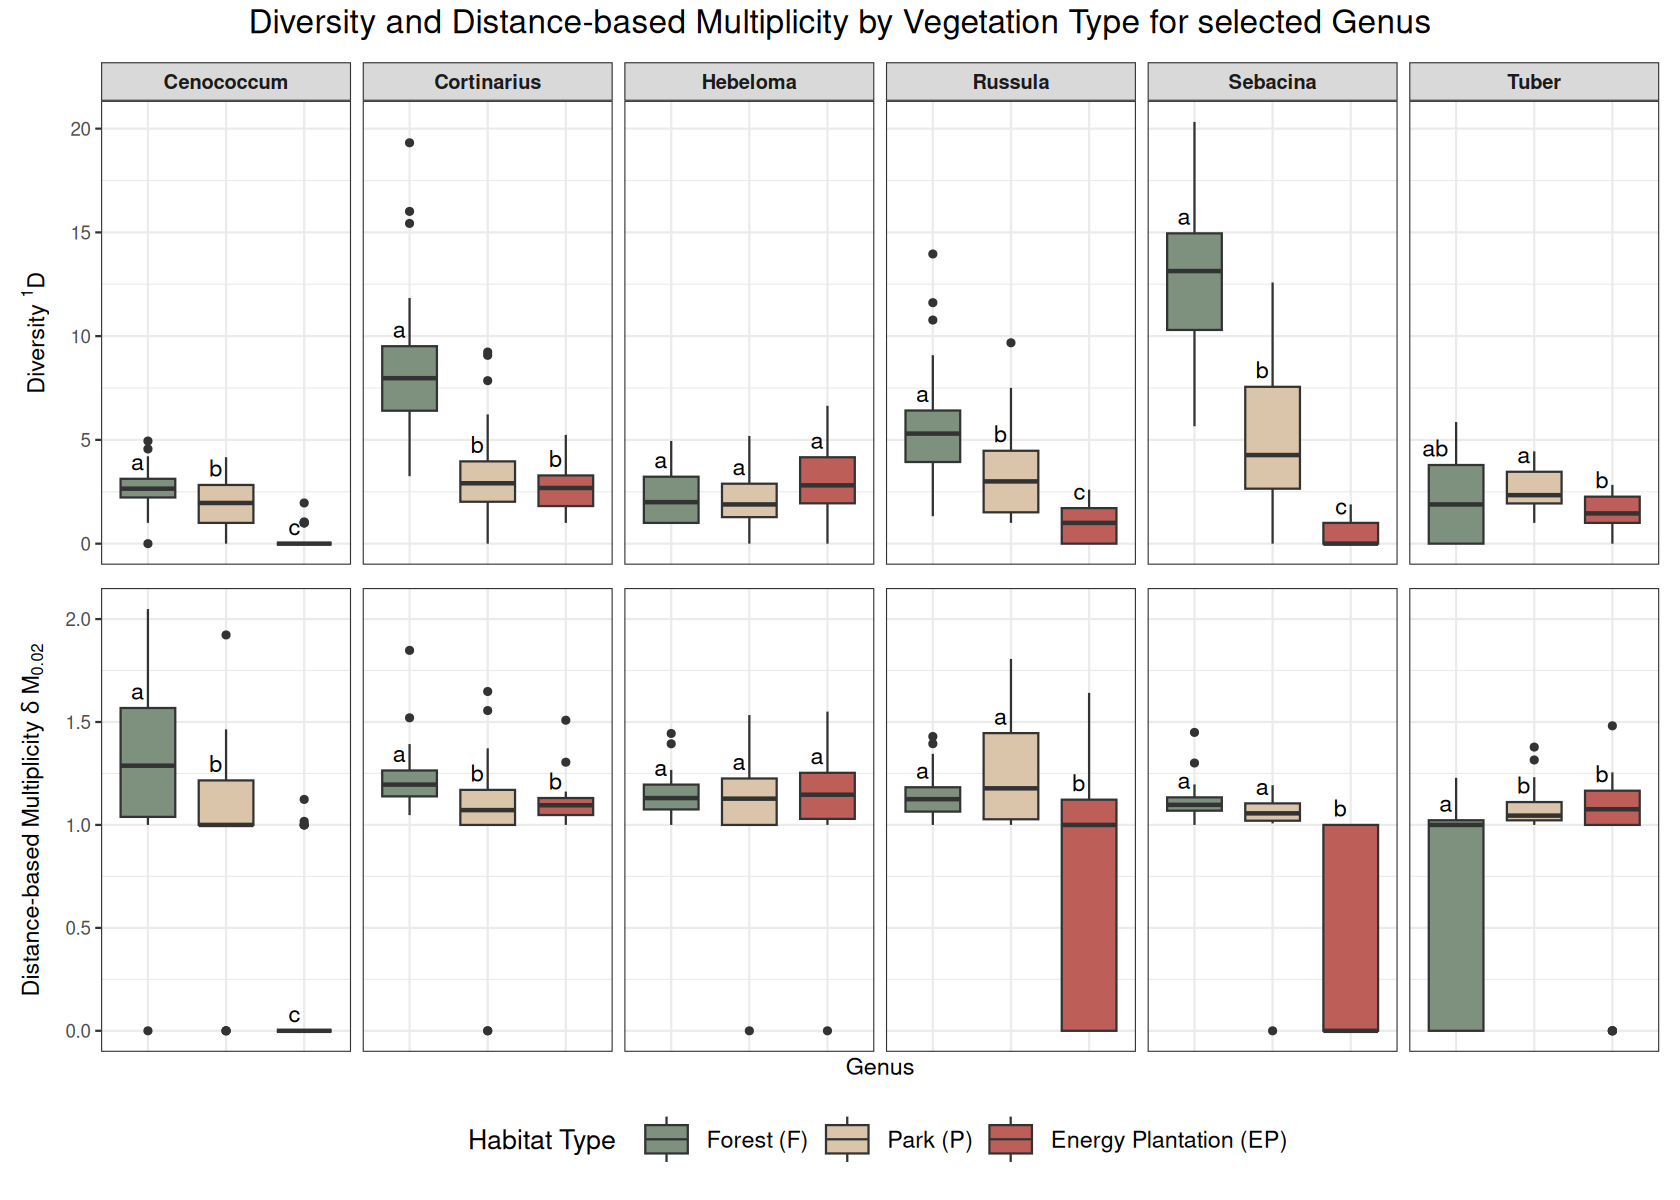

In [15]:
df_cld <- bind_rows(rows)

df <- df_analysis %>% filter(Taxa != "All")

label_order <- c('forest', 'park', 'energy plantation')

custom_colors <- c(
              '#7D917E',                 
              '#DAC5AA',
              '#BE5E58'
)

multiplicity_col <- "delta_M"
diversity_col <- "D"
group_col <- "Veg"

diversity_name <- "Diversity $^1D$"
group_name <- "Habitat Type"
multiplicity_name <- paste0("Distance-based Multiplicity $\\delta \\, M_{", sig, "}$", sep = "")


label_map <- c('forest' = "Forest (F)",                    
              'park' = 'Park (P)',                     
              'energy plantation' = "Energy Plantation (EP)"              
              )
              

p_div <- plot_taxa_boxplot(
  df = df,
  taxa_col = "Taxa",
  taxa_name = NULL,
  group_col = group_col,
  value_col = diversity_col,
  df_cld = df_cld,
  label_order = label_order,
  custom_colors = custom_colors,
  value_name = diversity_name,
  group_name = group_name,
  label_map = label_map  
) 

p_mult <- plot_taxa_boxplot(
  df = df,
  taxa_col = "Taxa",
  taxa_name = "Genus",
  group_col = group_col,
  value_col = multiplicity_col,
  df_cld = df_cld,
  label_order = label_order,
  custom_colors = custom_colors,
  value_name = multiplicity_name,
  group_name = group_name,
  label_map = label_map  
) 

# Set plot size
options(repr.plot.width = 14, repr.plot.height = 10)

p_mult <- p_mult + theme(
  strip.text.x = element_blank()   # Remove facet strip labels on bottom plot
)

combined <- (p_div / p_mult) +
  plot_layout(guides = "collect") +
  plot_annotation(
    title = "Diversity and Distance-based Multiplicity by Vegetation Type for selected Genus"
  ) &
  theme(
    legend.position = "bottom",               
    legend.text = element_text(size = 14),    
    legend.title = element_text(size = 16),  
    legend.key.size = unit(1.2, "cm"),        
    plot.title = element_text(size = 20, hjust = 0.5)
  )

combined

ggsave(paste0("EST-LAT/results/plots/", tolower(taxa_level), "_diversity_multiplicity_selected_baltics.png"), plot = combined, width = 14, height = 10, dpi = 400, bg = "white")
